# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats.mstats import pearsonr, spearmanr
import pywt

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
idx = pd.IndexSlice
%matplotlib inline


# Prepare the training dataframe and universe selection

In [2]:
# Import price and volume time series of the primary equities we'll be forecasting.
prices_import = pd.read_csv("train_files/stock_prices.csv", parse_dates=['Date'])
prices = prices_import.rename({'SecuritiesCode':'Code'}, axis = 1).set_index(keys = ['Code', 'Date']).sort_index().copy()
print("The train data begins on {} and ends on {}.\n".format(prices_import['Date'].min(), prices_import['Date'].max()))

# Imoprt a dataframe about the tags and characteristics of a stock (i.e it's sector and market segment)
stock_stats = pd.read_csv("stock_list.csv")
stock_stats = stock_stats.rename({'SecuritiesCode':'Code'}, axis = 1).set_index('Code')

dates = prices.index.get_level_values(1).unique()
securities = prices.index.get_level_values(0).unique()

# Import prices from the secondary data frame
# This data frame will contain the market index we'll use to compute a stock's beta.
secondary_prices_import = pd.read_csv('train_files/secondary_stock_prices.csv').rename({'SecuritiesCode':'Code'}, axis = 1)
secondary_prices_import['Date'] = pd.to_datetime(secondary_prices_import.Date)
secondary_prices_import = secondary_prices_import.set_index(['Code', 'Date']).sort_index()

The train data begins on 2017-01-04 00:00:00 and ends on 2021-12-03 00:00:00.



## Filter out late IPOs

<font size = 5>

Stocks that IPO'd in the middle of the dataset's time period won't be included.

In [3]:
# Check if each security has a complete date set
date_set = (prices.groupby('Code', group_keys=False).apply(lambda x: dates.isin(x.index.get_level_values(1)).all()))
lateIPO_securities = date_set[~date_set].index
earlyIPO_securities = date_set[date_set].index

# Security 3540 has entries in 2017, but they're nan's
prices = prices.loc[earlyIPO_securities].drop(3540, errors='ignore').copy()

# Security code 1320 is a good approximation to the Nikkei 225 index
prices = pd.concat([prices, secondary_prices_import.loc[idx[1320, :],:]]).sort_index()


## Appending the market index 

<font size = 5>

The market index I'll use is Daiwa ETF-Nikkei 225 which corresponds to securities code:1320.  It's located in the `secondary_prices` dataset.

Text(0.5, 1.0, 'Daiwa ETF-Nikkei 225 index ETF\nSecurity code 1320')

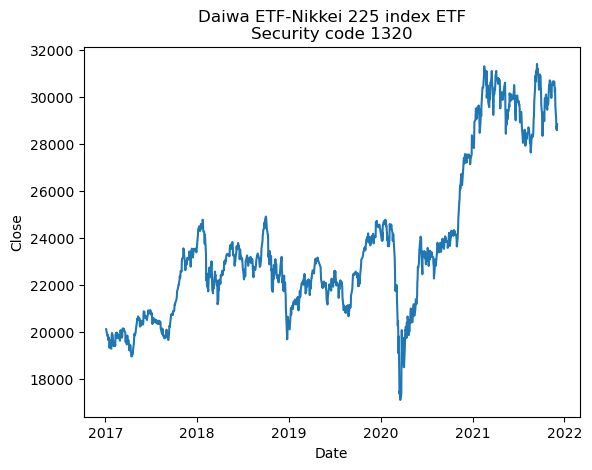

In [4]:
fig, ax = plt.subplots()
sns.lineplot(data = prices.loc[1320], x='Date', y='Close')
market_index_name = stock_stats.loc[1320, 'Name']
ax.set_title(f'{market_index_name} index ETF\nSecurity code 1320')

<!-- ## Merging fundamental data
not working at the moment because of forecast revisions -->

## Filtering out bad days
There was a bizarre computer outage on 2020-10-01 in the JPY exchange, so that day will get thrown out from the training data set.


In [5]:
train = prices.copy()
train = train[train.index.get_level_values(1) != '2020-10-01']

# train_dup = train.index[train.index.duplicated()]

# for entries with no volume, make the OHLC the previous days close
# It might make sense to throw these training examples out since there's no actvitiy here
no_volume = train['Volume'] == 0
# train['Close'] =train.groupby('Code')['Close'].bfill()
# train.loc[no_volume, ['Open', 'High', 'Low']] = train.loc[no_volume, 'Close']

# Security 3540 has nan's for its pricing data up until 2018.
# It'll just get removed
universe_list = train.index.get_level_values('Code').drop_duplicates().to_list()
universe_stats = stock_stats.loc[universe_list]
display(universe_stats['Section/Products'].value_counts())

Section/Products
First Section (Domestic)       1646
JASDAQ(Standard / Domestic)     102
Second Section(Domestic)         85
Mothers (Domestic)               24
JASDAQ(Growth/Domestic)           7
ETFs/ ETNs                        1
Name: count, dtype: int64

## Universe selection conclusion
* We've constrained our universe to be Japanese businesses.  The only ETF that is included in the universe list should be the Nikkei 225 ETF that we intentionally included to act as our market index. 

# Returns EDA

In [6]:
# Use the adjusted close and volume to compute the beta
train['CumulativeAdjustmentFactor'] = train.groupby('Code', group_keys=False)['AdjustmentFactor'].cumprod().shift(1)
train.loc[idx[:, '2017-01-04'], 'CumulativeAdjustmentFactor']=1

train['AdjClose'] = train['Close'] / train['CumulativeAdjustmentFactor']
train['AdjVolume'] = train['Volume'] * train['CumulativeAdjustmentFactor']

# train['AdjClose'] =train.groupby('Code', group_keys=False).apply(
#     lambda x: x['Close'] / (x['AdjustmentFactor'].cumprod()))
# train['AdjVolume'] =train.groupby('Code', group_keys=False).apply(
#     lambda x: x['Volume'] * (x['AdjustmentFactor'].cumprod()))
train['DollarVolume'] = train['AdjClose'] * train['AdjVolume']

train['Return'] = train.groupby('Code', group_keys=False)['AdjClose'].pct_change(fill_method=None)
train['CumulativeReturn'] = train.groupby('Code', group_keys=False)['Return'].apply(
    lambda x: (1+x).cumprod())

train['ReturnFwd1d'] = train.groupby('Code', group_keys=False)['Return'].shift(-1)




# Since I'm not using the kaggle target I'll just drop it
train.drop('Target', axis=1, errors='ignore', inplace=True)

#OLD CODE
# there are some bad reporting days that cause the returns to be incorrect.
# In the original kaggle challenge, the target was simple returns shifted ahead by 2 days. 
# So the simple returns hsould be the target lagged by 2 periods.
# train['returns'] = train.groupby('Code', group_keys=False)['Target'].shift(2)


In [7]:
# OLD CODE that was meant to analyze outlier returns

# naughty_list = [1780, 1799, 1802, 1808, 1812, 1813, 1814, 1820, 1821, 1822]

# fig, ax = plt.subplots(len(naughty_list), 1, figsize=np.array([9.2, 5.6*len(naughty_list)/1.25]))

# for i, bad_ticker in enumerate(naughty_list):
#     ax[i].set_title(f'Security code:{bad_ticker}')
#     sns.lineplot(train.loc[bad_ticker], x='Date', y='AdjClose', ax=ax[i])
#     sns.scatterplot(train.loc[bad_ticker], x='Date', y='CumulativeAdjustmentFactor', ax=ax[i].twinx(), color='tab:orange')


## Universe statistics

<font size = 4>

Groupby the security code and compute statistics on the daily `Return`

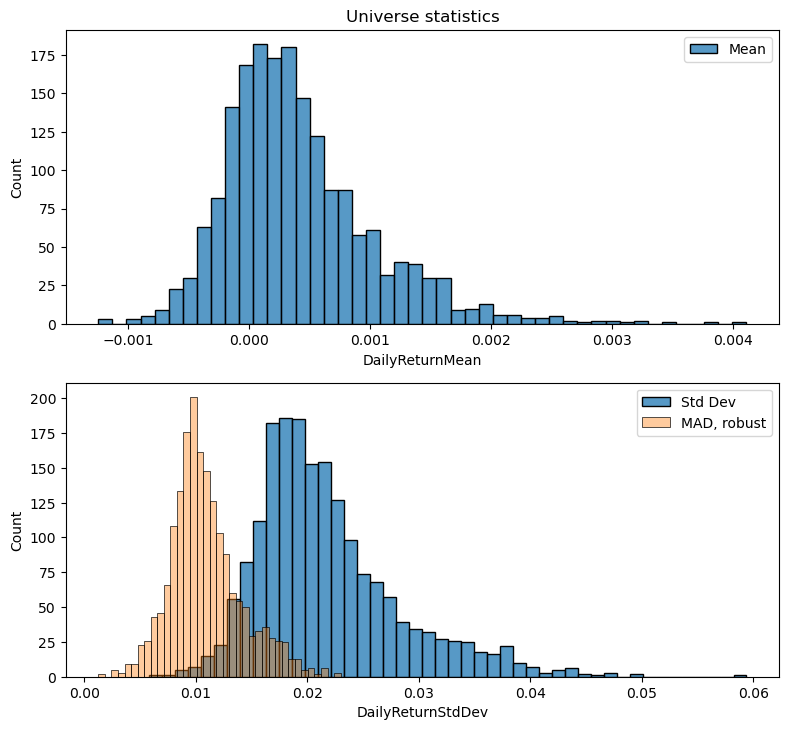

In [8]:
universe_stats['OverallReturn'] = train.groupby('Code', group_keys=False)['CumulativeReturn'].apply(lambda x: x.iloc[-1])
universe_stats['DailyReturnMean'] = train.groupby('Code', group_keys=False)['Return'].mean()
universe_stats['DailyReturnStdDev'] = train.groupby('Code', group_keys=False)['Return'].std()
universe_stats['DailyReturnMedian'] = train.groupby('Code', group_keys=False)['Return'].median()
universe_stats['DailyReturnMAD'] = train.groupby('Code', group_keys=False)['Return'].apply(
    lambda x: np.abs((x - x.median())).median()
)

fig, ax = plt.subplots(2, 1, figsize = (9.2, 5.6*1.5))
axa, axb = ax

axa.set_title('Universe statistics')

sns.histplot(universe_stats, x='DailyReturnMean', label='Mean', ax=axa)

sns.histplot(universe_stats, x='DailyReturnStdDev', label='Std Dev', ax=axb)
sns.histplot(universe_stats, x='DailyReturnMAD', label='MAD, robust', ax=axb, alpha=0.4 )

axa.legend()
axb.legend()



<font size = 5>

* Top histogram
    * Median returns is excluded because those are typically zero
    * Asymmetry in the mean daily returns is expected

* Bottom plot
    * The median absolute deviation (MAD) estimate is a more conservative estimate of the spread in the daily returns.
    * Elements of Quantitative Investing by Paleologo suggests using MAD to winsorize returns.

## Returns winsorization

Source: GA Paleologo Elements of Quantitative Investing

<img src='figures/gappy-winsorization.png'>

In [9]:
from scipy.stats.mstats import winsorize

def WinsorizeReturns_robustZ(series:pd.Series, fraction):
    log_return = series.apply(np.log1p)
    mad = log_return.apply(np.abs).median()

    # mind the absolute value sign on the numerator
    robust_zscore = np.abs(log_return) / mad

    # Use a single tailed quanitle
    zscore_quantile = robust_zscore.quantile(fraction) 

    # The quantile to clip should be no smaller than 5,
    # and no larger than 10 (ref: EQI Gappy)
    zscore_quantile = max(5, min(zscore_quantile, 10))
    winsor_limit = (robust_zscore >= zscore_quantile).mean()

    winsorized_zscore = winsorize(robust_zscore, limits=winsor_limit, nan_policy='omit')
    winsorized_series = pd.Series(
        winsorized_zscore * mad * np.sign(log_return).values,
        index=series.index)
    output = {
        'winsorized_series': winsorized_series,
        'zscore_quantile': zscore_quantile,
        'winsor_limit': winsor_limit
    }
    return pd.DataFrame(output, index=series.index)

winsorized_result = train.groupby('Code', group_keys=False)['Return'].apply(
    WinsorizeReturns_robustZ, fraction=0.994)

train['WinsorReturn'] = winsorized_result['winsorized_series']
universe_stats['winsor_limit'] = winsorized_result['winsor_limit'].groupby('Code').mean()
universe_stats['robustZ_WinsorCutoff'] = winsorized_result['zscore_quantile'].groupby('Code').mean()

train['WinsorCumulativeReturn'] = train.groupby('Code', group_keys=False)['WinsorReturn'].apply(
    lambda x: (1+x).cumprod()
)

In [10]:
train['WinsorCumulativeReturn'] = train.groupby('Code', group_keys=False)['WinsorReturn'].apply(
    lambda x: (1+x).cumprod()
)

Text(0.5, 0, '$d_{max}$')

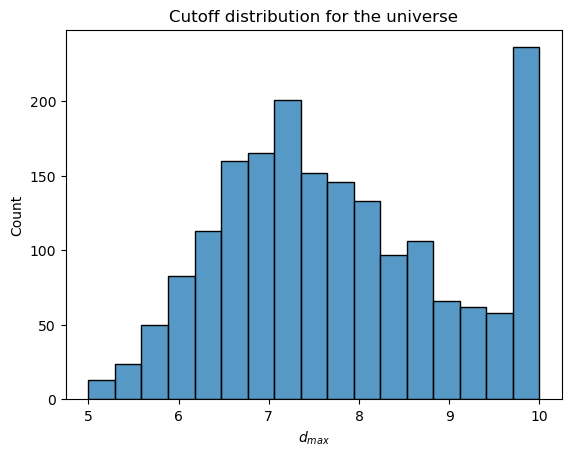

In [11]:
fig, ax = plt.subplots()

sns.histplot(universe_stats, x='robustZ_WinsorCutoff')
ax.set_title('Cutoff distribution for the universe')
ax.set_xlabel(r'$d_{max}$')
# sns.histplot(universe_stats, x='winsor_limit')

<font size = 4>

* GA Paleologo recommends to use winsorization on the aboslute value of the robust z score of the returns.
* The cutoff should be between 5 and 10, and fine tuned by trial and error.
* Using a `fraction=0.994` or a winsorization limit of 0.6%, the cutoff's are roughly centrally distributed around 7.
* The fat tail at 10 must be coming from securities that had massive growth and decline.  

Code
9873    0.065779
2705    0.038301
2669    0.031640
2268    0.025812
8198    0.024147
9631    0.023314
2686    0.020816
3075    0.018318
1981    0.017485
3157    0.017485
Name: winsor_limit, dtype: float64

<Axes: title={'center': 'Security code 9873'}, xlabel='Date', ylabel='CumulativeReturn'>

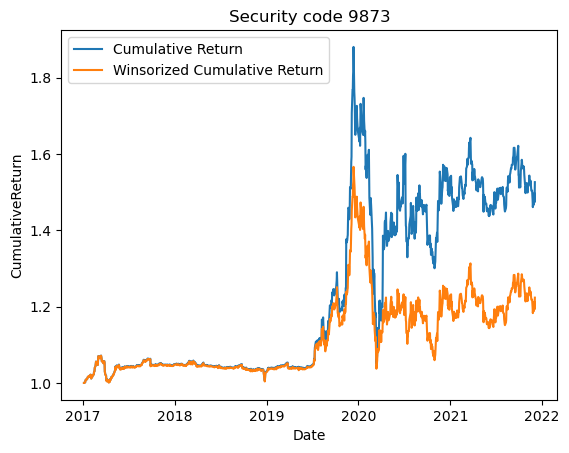

In [12]:
display(universe_stats['winsor_limit'].nlargest(10))
fig, ax = plt.subplots()

security = 9873
ax.set_title(f'Security code {security}')
sns.lineplot(train.loc[security], x='Date', y='CumulativeReturn', label='Cumulative Return')
sns.lineplot(train.loc[security], x='Date', y='WinsorCumulativeReturn', label='Winsorized Cumulative Return')

<font size=5>

* Security 9873 had to be winsorized the most, with 6.5% of its returns being winsorized.

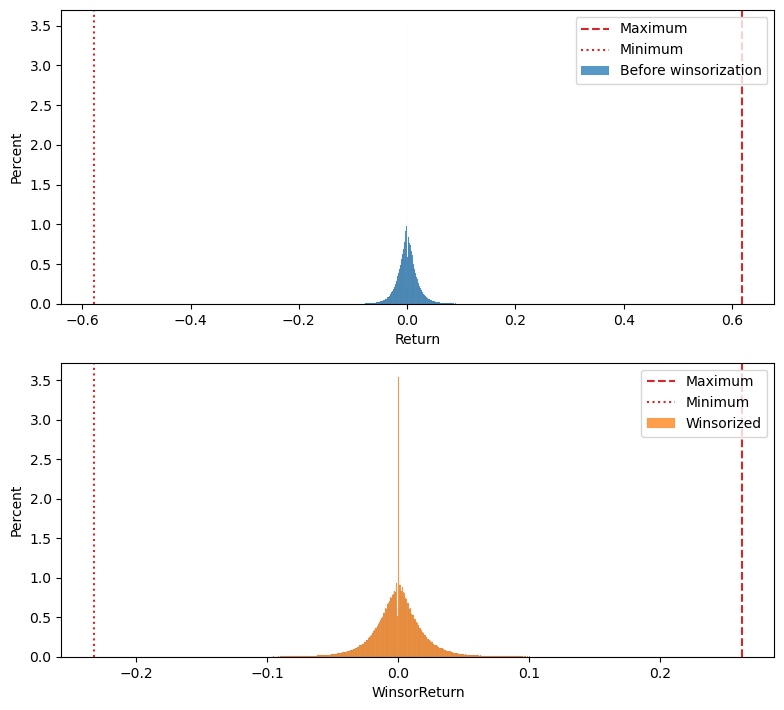

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(9.2, 5.6*1.5))
sns.histplot(train, x='Return', label='Before winsorization', stat='percent', ax=ax[0])
ax[0].axvline(train['Return'].max(), color='tab:red', linestyle='--', label='Maximum')
ax[0].axvline(train['Return'].min(), color='tab:red', linestyle=':', label='Minimum')

sns.histplot(train, x='WinsorReturn', label='Winsorized', stat='percent', color='tab:orange', ax=ax[1])
ax[1].axvline(train['WinsorReturn'].max(), color='tab:red', linestyle='--', label='Maximum')
ax[1].axvline(train['WinsorReturn'].min(), color='tab:red', linestyle=':', label='Minimum')

for a in ax: a.legend()

<font size = 5>

* Q: Why are there so many 0 return days?

* A: Because the data source rounded the prices to the nearest yen.

* The extent of the winsorized return distribution is reduced, with max and min at $\approx \pm 0.25$

# Calculating $\beta$

$$
\beta_e = \frac{\text{Cov}(R_{e}, R_{m})}{\text{Var}(R_m)}
$$
* $\beta_e$ explains the contribution of volatility in an equity that is derived from the systematic risk in the overall market.
* $R_e$ is the daily return of a stock price.
* $R_m$ is the daily return in a market index.

An appropriate estimator for the covariance of two random variables would be

$$
\text{Cov}(X, Y) = \frac{1}{n-1} \sum_{i=1}^{n}{ \left(X_i - \bar{X}\right) \left(Y_i - \bar{Y}\right)}
$$

Where $\bar{X}$ is the estimator for the mean of $X$.  Estimators for covariance and mean should converge to their true population statistic by WLLN.  If we set $n=45$ and using a moving average approach, we can compute the 45 day $\beta$.

Targets:
* Forecast the 45 day average $beta$ for the next day
* Forecast the 45 day average $beta$ 45 days from now
 
 Checking the autocorrelation of the $\beta$ would indicate how hard it is to forecast $\beta$ far into the future.

 Note $\beta$ is also the coefficient if we regress the stock returns against the market returns (and so could be computed from matrix multiplication and inversion of $A^TA$).


* `beta_45avg` is computed using 45 days of returns of a stock and the market.  This is a "historical" beta that depends on data that has been recorded.
* `beta_45avg_1` would be tomorrow's 45 day averaged beta.  We should expect this time series to have strong correlation with the historical `beta_45avg` because only 1/45 days is unknown to us, and is likely to have weak contribution in comparison to the other 44 days.
* A natural thing to check would be the autocorrelation.

In [14]:
market_df = train.loc[1320]
# forecast window
target_window_span = 45
# forward_window = pd.api.indexers.FixedForwardWindowIndexer(window_size=target_window_span)

def wavelet_smooth(signal, threshold = 0.2, level =3, wavelet = 'db6'):

    coeff = pywt.wavedec(signal, wavelet, mode = 'per', level =level)
    coeff[1:]  = [pywt.threshold(i, value=threshold*np.abs(signal.max()), mode = 'soft') for i in coeff[1:]]
    clean_signal = pywt.waverec(coeff, wavelet, mode = 'per')
    # return clean_signal
    if len(signal)%2 == 1:
        clean_series= pd.Series(clean_signal[:-1], signal.index)
    else:
        clean_series =  pd.Series(clean_signal, signal.index)
    return clean_series

def rolling_beta(df:pd.DataFrame, rolling_window, column, market_df=market_df):
    Y_series= df[column]
    X_series = market_df[column]
    XY_series = X_series * Y_series
    XY_mean = XY_series.rolling(window=rolling_window).mean()
    X_mean = X_series.rolling(window=rolling_window).mean()
    Y_mean = Y_series.rolling(window=rolling_window).mean()
    X_variance = X_series.rolling(window=rolling_window).var()
    return (XY_mean - X_mean * Y_mean) / X_variance


train['beta_45avg']=train.groupby('Code', group_keys=False).apply(
    rolling_beta, rolling_window=target_window_span, column='WinsorReturn'
)

# we use ffill to populate time series who's values we are unsure of.
# bfill would constitute a lookahead bias, who's severity would depend on 
# the span of the averaging window.
train['beta_target_1'] =  train.groupby('Code', group_keys=False)['beta_45avg'].shift(-1).ffill()
train['beta_target_5'] =  train.groupby('Code', group_keys=False)['beta_45avg'].shift(-5).ffill()
train['beta_target_20'] = train.groupby('Code', group_keys=False)['beta_45avg'].shift(-20).ffill()
train['beta_target_45'] = train.groupby('Code', group_keys=False)['beta_45avg'].shift(-45).ffill()

beta_autocorrelation = np.array([
    train['beta_45avg'].autocorr(i) for i in range (1, 91)
])
# OLD CODE
# train['beta_target']=train['beta_target_45']
# train['dbeta'] = train.groupby('Code', group_keys=False)['beta_target'].apply(lambda x: x.diff().fillna(x.diff().mean()))
# train['dbeta_sm']=train.groupby('Code', group_keys = False)['dbeta'].apply(wavelet_smooth, level = 4, threshold = 0.15)


## View a few $\beta$ time series
* To give some confidence we've computed the $\beta$ correctly, we might just look at their time series for a few stocks.  
* We'll look at the top 3 beta stocks, the median 3 beta stocks, and the 3 lowest $\beta$ stocks.

In [15]:
sec_stats = pd.DataFrame(index = train.index.get_level_values(0).unique())
sec_stats['avg_beta'] = train.groupby('Code', group_keys=False)['beta_45avg'].mean()
sec_stats['beta_rank'] = np.abs(sec_stats.avg_beta).rank(ascending = False)
sec_stats.sort_values(by = 'beta_rank',inplace=True)

top3_betas = sec_stats.head(3).index.get_level_values('Code').to_list()
bottom3_betas = sec_stats.tail(3).index.get_level_values('Code').to_list()

median_betas = sec_stats.loc[sec_stats['avg_beta'].between(
    sec_stats['avg_beta'].quantile(0.499),
    sec_stats['avg_beta'].quantile(0.501),
)].index.get_level_values('Code').to_list()

def plot_target_timeseries(tickers:list, targets:list=None, df:pd.DataFrame =None):
    if df ==None: df =  train
    if targets == None: targets = ['beta_45avg']
    targets = ['CumulativeReturn'] + targets

    fig, ax = plt.subplots(len(tickers), len(targets), figsize = (14,10))
    for i, tick in enumerate(tickers):
        ax[i, 0].set_title('Security code {:}'.format(tick))
        ax[i, 1].set_title('beta rank {:}\n mean beta={:.3g}'.format(*sec_stats.loc[tick, ['beta_rank', 'avg_beta']]))
        for j, targ in enumerate(targets):
            sns.lineplot(df.loc[tick], x= 'Date', y = targ, ax = ax[i, j])

    fig.tight_layout()

### Top 3 high $\beta$ stocks

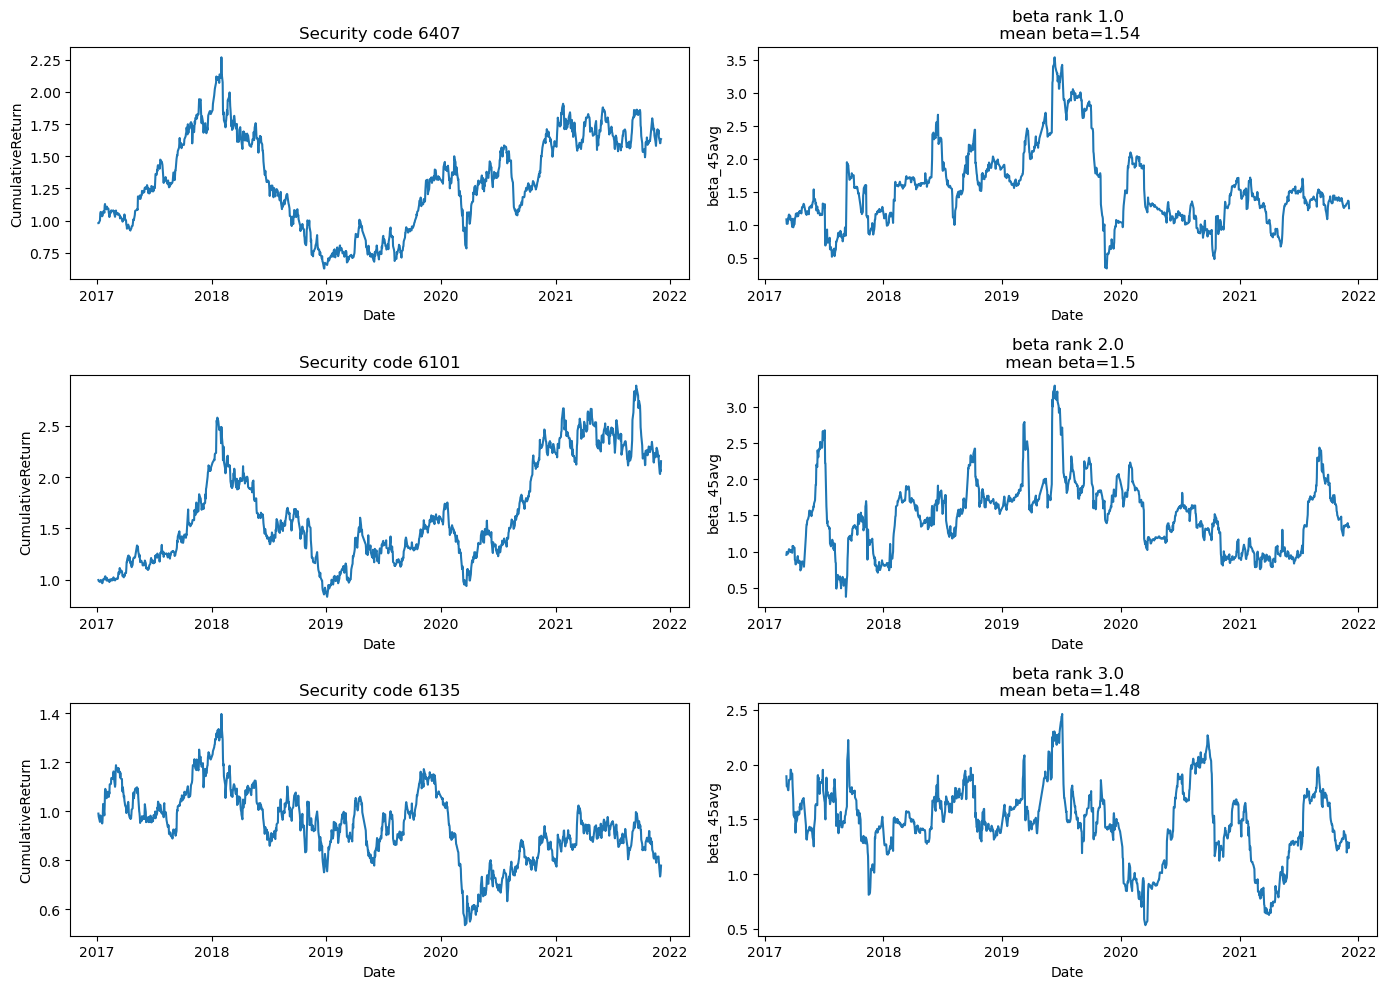

In [16]:
plot_target_timeseries(top3_betas, ['beta_45avg'])
# plot_target_timeseries(top3_alphas)

### Median $\beta$ stocks

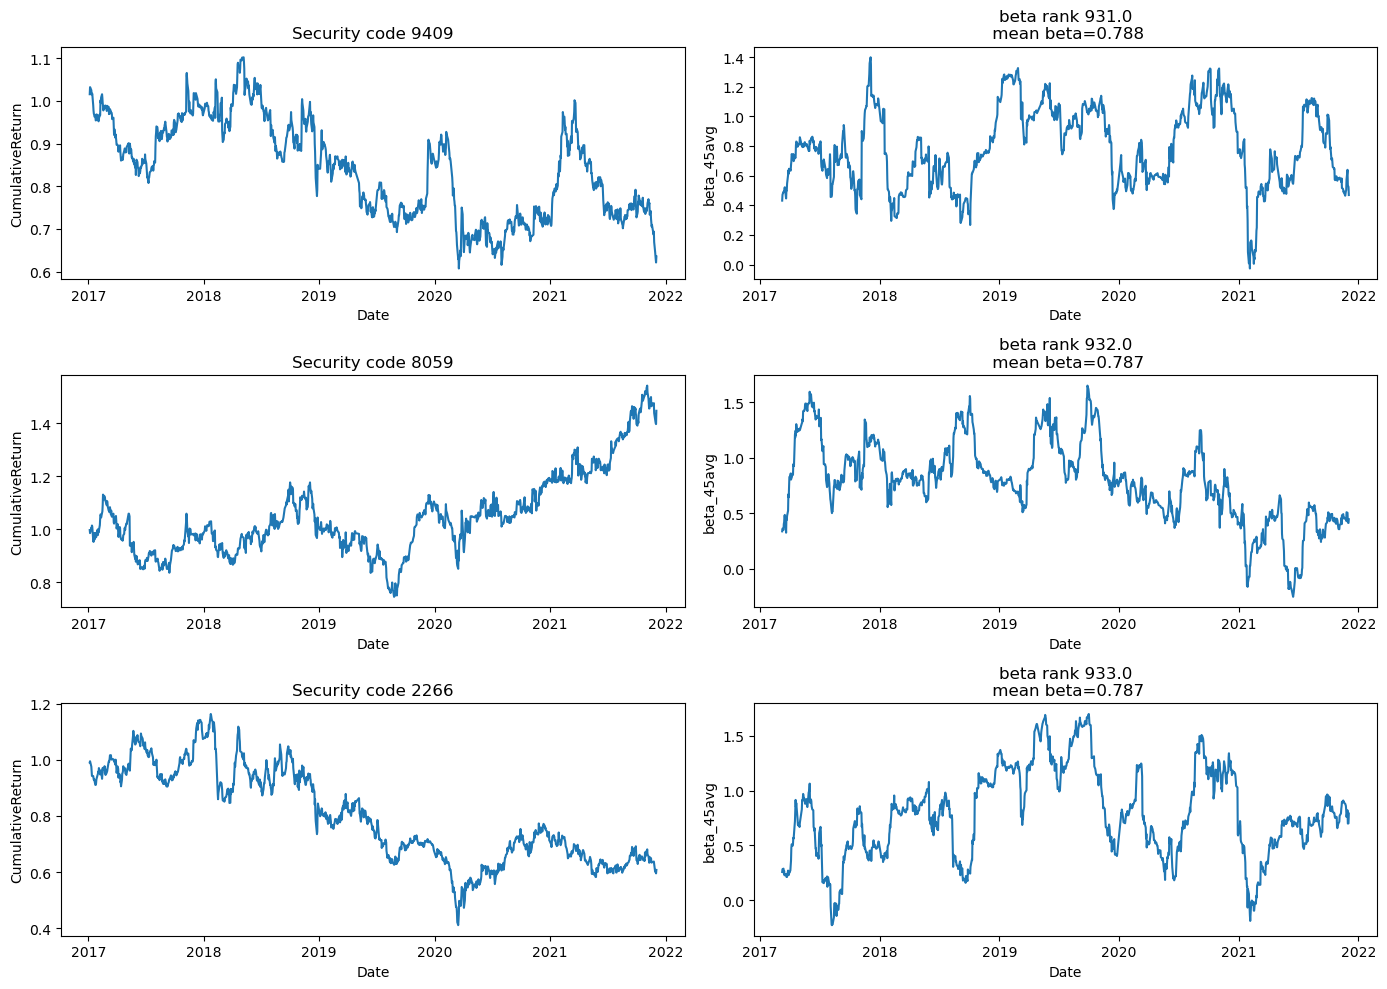

In [17]:
plot_target_timeseries(median_betas, ['beta_45avg'])

### Bottom 3 $\beta$ stocks

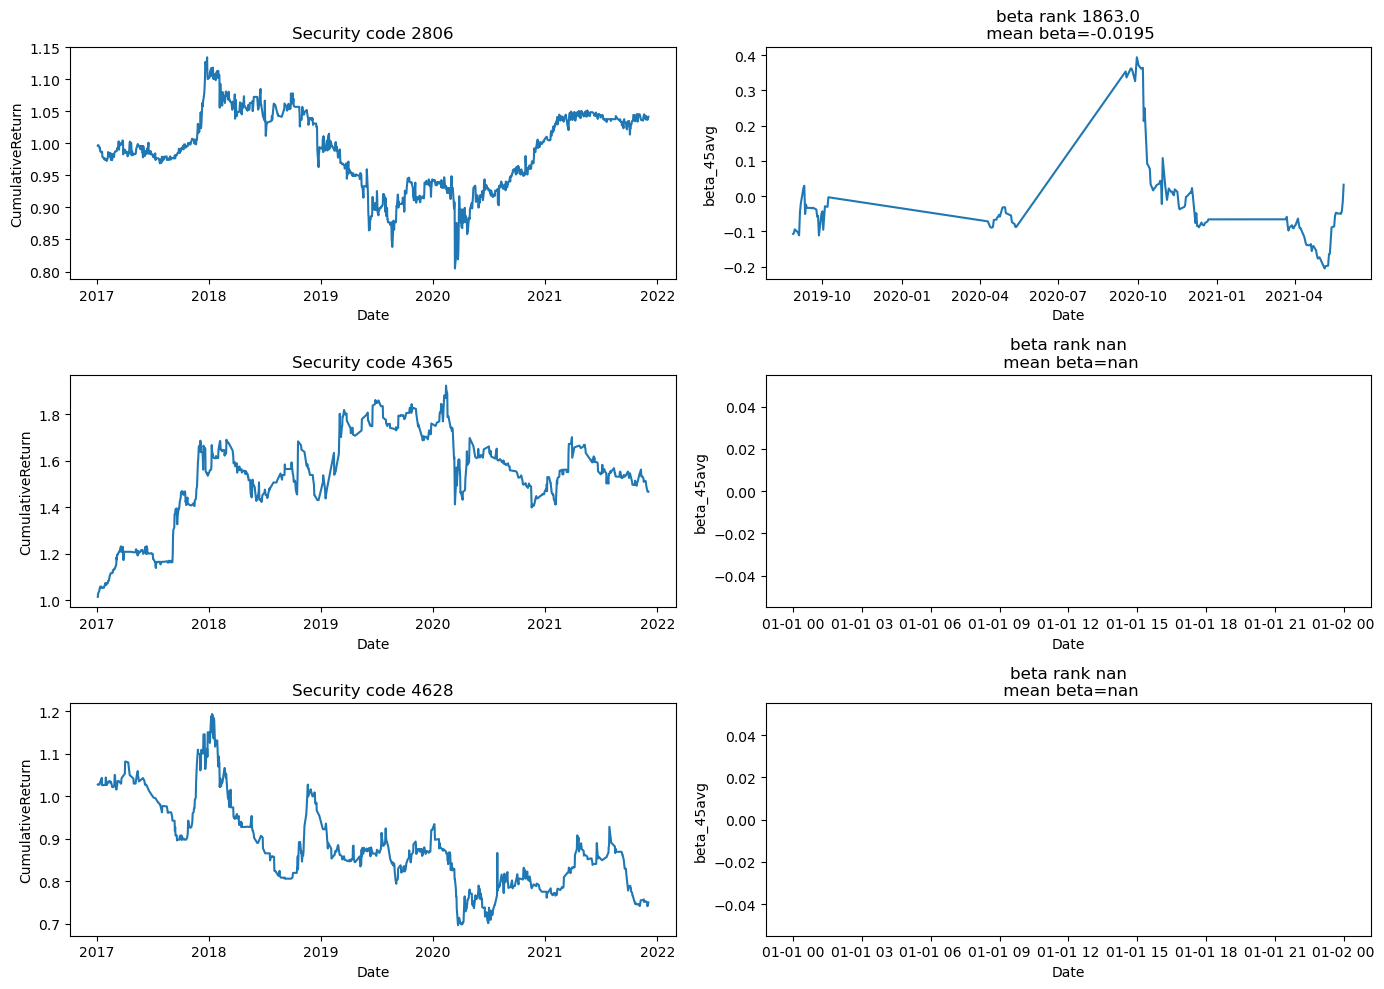

In [18]:
plot_target_timeseries(bottom3_betas, ['beta_45avg'])

<font size = 4>

* Seems a little strange that low beta stocks have outperformed some mid tier beta stocks (i.e. security 9539 in the bottom tier has outperformed 4997 in the mid tier).  But this is just few particular examples so it seems possible. 
* There seems to be no evidence that $\beta$ was incorrectly computed so I will continue with feature engineering.

### Distribution of betas

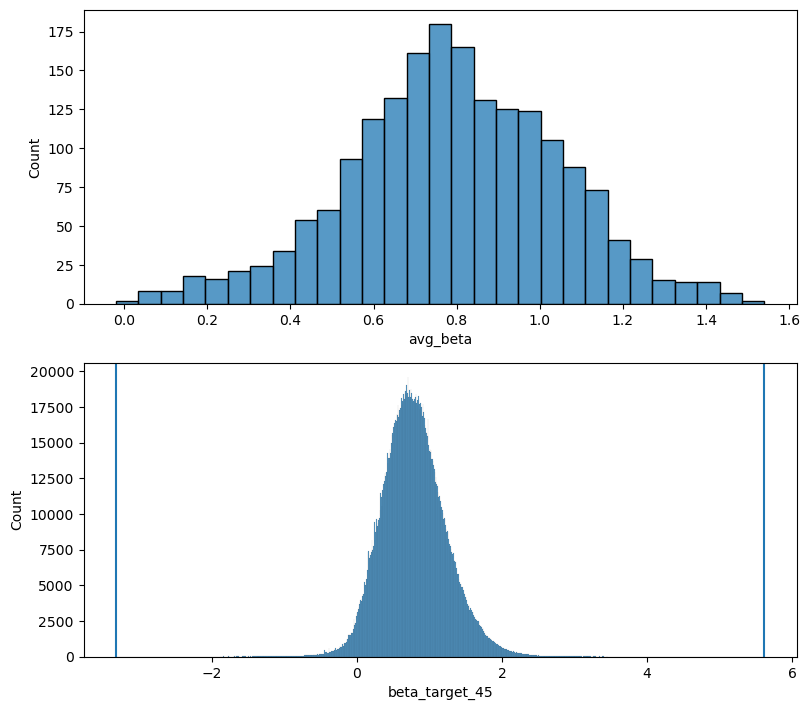

In [19]:
fig, ax = plt.subplots(2, 1, figsize = (9.2, 5.6*1.5))
axa, axb = ax
sns.histplot(sec_stats, x='avg_beta', ax=axa)
sns.histplot(train, x='beta_target_45', ax=axb)

axb.axvline(train['beta_target_45'].max())
axb.axvline(train['beta_target_45'].min())

<font size = 4>

* Top plot is a distribution of the average $\beta$ in the universe
* Bottom plot is a distribution of the $\beta$ in the entire dataset
* Seems like there's a small mode of low beta equities in the dataset

## Autocorrelation in the 45 day $\beta$

$$
\rho(k) = \frac{ \text{Cov}(X_t, X_{t-k}) } { \text{Var}(X_t) }
$$

Where $\rho(k)$ is a measure of how correlated a time series is with itself, but lagged by a period of $k$

Text(0, 0.5, 'Autocorrelation')

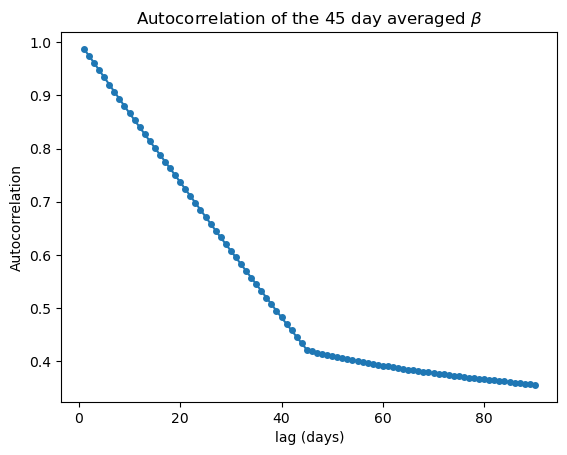

In [20]:
# train['beta_45avg'].autocorr(4)
fig, ax = plt.subplots()
ax.plot(np.arange(1, 91),beta_autocorrelation, 'o-', markersize = 4)
ax.set_title(r'Autocorrelation of the 45 day averaged $\beta$ ')
ax.set_xlabel(r'lag (days)')
ax.set_ylabel(r'Autocorrelation')

# ax.axhline(0.7, color='k', linestyle='--')

* The broad minimum near the 65 day lag seems a little strange, but the fact that it's extremely broad makes me less concerned.

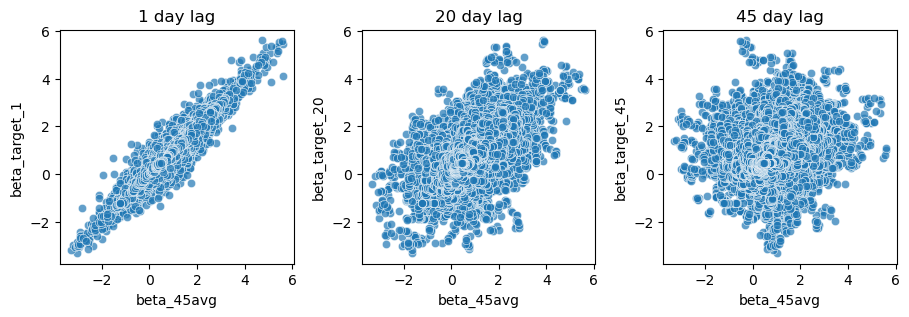

In [21]:
fig, ax = plt.subplots(1, 3, tight_layout=True, figsize = (9.2, 5.6))


sns.scatterplot(train, x='beta_45avg', y='beta_target_1' , alpha = 0.7, ax=ax[0]) 
sns.scatterplot(train, x='beta_45avg', y='beta_target_20',  alpha = 0.7, ax=ax[1])
sns.scatterplot(train, x='beta_45avg', y='beta_target_45',  alpha = 0.7, ax=ax[2])

ax[0].set_title('1 day lag')
ax[1].set_title('20 day lag')
ax[2].set_title('45 day lag')
for a in ax: a.set_aspect('equal')

* The autocorrelation seems to plateau past a lag of ~42 periods.  
* Forecasting the 45 day average $\beta$, 45 days from now seems to be as tough as it gets.

This qualitatively makes a lot of sense. If the lag, $k$ is less than the window span, then I don't really have to forecast a 45 day statistic, I only have to forecast a statistic over the span of $k$ days.


In [22]:
# FUNDAMENTAL DATA #
# still in progress

# fund_import = pd.read_csv('train_files/financials.csv').rename(columns ={'SecuritiesCode': 'Code'})
# fund_import = fund_import[~fund_import['Code'].isna()]
# fund_import['Code']=fund_import['Code'].astype(int)
# fund_import['Date'] = pd.to_datetime(fund_import['Date'])
# fund_import = fund_import.set_index(['Code', 'Date']).sort_index()

# quarterly_report_features = [
#     'TypeOfDocument',
#     'EarningsPerShare', 
#     'Equity', 'EquityToAssetRatio', 'TotalAssets',
#     'NetSales',
#     'OperatingProfit', 'OrdinaryProfit', 'Profit', 
#     'BookValuePerShare', 
#     'ResultDividendPerShare1stQuarter',
#     'ResultDividendPerShare2ndQuarter',
#     'ResultDividendPerShare3rdQuarter',
#     'ResultDividendPerShareAnnual',
#     'ResultDividendPerShareFiscalYearEnd',
# ]

# forecasted_fundamental_features =[
#     'ForecastDividendPerShare1stQuarter',
#     'ForecastDividendPerShare2ndQuarter',
#     'ForecastDividendPerShare3rdQuarter',
#     'ForecastDividendPerShareFiscalYearEnd',
#     'ForecastNetSales',
#     'ForecastOperatingProfit',
#     'ForecastOrdinaryProfit',
#     'ForecastProfit',
#     'ForecastEarningsPerShare'
# ]
# fundamental_features = quarterly_report_features + forecasted_fundamental_features
# fund_import[fundamental_features[1:]]= fund_import[fundamental_features[1:]].apply(pd.to_numeric, errors='coerce')
# fundamental = fund_import[fundamental_features]
# fund_dup = fund_import.index[fund_import.index.duplicated()]


# fund_import.loc[fund_dup[6], :].T

# Feature engineering


* price features
    * standard deviation in returns
    * Bollinger band feature
    * ratio of return to market avg returns
    * average true range 
    * other candle features
    

* Implied volatility of atm options

**I would doubt any feature that had a correlation larger than 0.4 (in absolute magnitude) with the $\beta$ 45 days from now**

If the target has weak correlation with its lagged series, then it seems tough to find a feature that could do better.

In [23]:

# Feature calculation functions

def pandas_winsor(series, limit = 1-0.99):
    return pd.Series(winsorize(series, limits = limit).data, index =series.index)


# Plotting methods

def feature_timeseries_plot(tickers:list, feature, target, df:pd.DataFrame = None):
    if df == None: df = train

    fig, ax = plt.subplots(2, len(tickers), figsize = (14, 10))

    for i , tick in enumerate(tickers):
        ax[0, i].set_title('Security code {:}'.format(tick))
        ax[1, i].set_title('beta rank {:}'.format(sec_stats.loc[tick, 'beta_rank']))        
        sns.lineplot(df.loc[tick], x= 'Date', y = target, ax = ax[0, i])
        sns.lineplot(df.loc[tick], x= 'Date', y = feature, ax = ax[1, i])
    return

def beta_feature_scatter(feature, spearman = False, df:pd.DataFrame = None,):
    '''
    2 scatter plots of the beta and beta differences vs. the feature
    '''
    fig, ax = plt.subplots(ncols= 2, figsize = (9.2*1.5,5.6))
    feature_scatter(feature, 'beta_target_45', spearman, df, fig =fig, ax = ax[0])
    # feature_scatter(feature, 'dbeta_sm', df=df,fig =fig, ax = ax[1])

def feature_scatter(feature, target, spearman=False, df:pd.DataFrame=None, fig =None, ax = None):

    if df ==None:
        df = train.loc[train.index.get_level_values(0)!=1320]
    if ax ==None:
        fig, ax = plt.subplots()
    df=df[[feature, target]].dropna()
    sns.scatterplot(data = df, x = feature, y = target, ax = ax)

    pearson_r = pearsonr(df[feature], df[target])[0]
    print(f'{target} vs {feature} pearson r={pearson_r}')
    ax.set_title('{:} has pearson r of {:.3g}'.format(feature, pearson_r))

    if spearman:
        spearman_r = spearmanr(df[feature], df[target])[0]
        print(f'{target} vs {feature} spearman r={spearman_r}')
    
def feature_heatmap(feat_list:list,targets:list = None, data:pd.DataFrame =None, ):
    '''
    Plots a heat map of the correaltion matrix
    '''
    fig, ax = plt.subplots(figsize = (6, 6))

    if data == None: data = train
    if targets == None: targets = ['beta_target_45']
    cols = feat_list + targets
    sns.heatmap(data[cols].dropna().corr(), ax = ax, cmap = 'viridis',annot=True, fmt = '.2g')


## Symbol/ticker feature

* Work in progress
* I need to encode a categorical feature into a numerical feature to be compatible with linear and ridge regression modules from `sklearn`

In [24]:
train['symbol'] = train.index.get_level_values('Code').astype(str)
symbol_dicts = [{str(symbol): 1} for symbol in universe_list]

from sklearn.feature_extraction import FeatureHasher

hasher = FeatureHasher(n_features=13, input_type='dict')
hashed_tickers = hasher.transform(symbol_dicts)

collision_matrix = np.zeros(shape=hashed_tickers.shape)

for i, dict in enumerate(symbol_dicts):
    single_hashed = hasher.transform([dict]).toarray()
    collision_matrix[i] = single_hashed

column_sums = np.sum(np.abs(collision_matrix), axis=0)    
collision_check = np.any(column_sums > 1)

## Options
 TBD

In [25]:
# options_import = pd.read_csv('train_files/options.csv')
# options_import['Date'] = pd.to_datetime(options_import['Date'])
# options_import['Code']=options_import['OptionsCode'].astype(str).str[:4].astype(int)
# # options_import['id'] =options_import['DateCode'].astype(str).str[:13].astype(int)
# options_indices = [
#     'Code', 'Date',
#     'StrikePrice', 
#     # 'PutCall', 'ContractMonth',
# ]
# options_import = options_import.set_index(options_indices).sort_index()

# active_set = options_import['WholeDayVolume'] >1000
# options = options_import[active_set].copy()
# fig, ax = plt.subplots()

# # sns.histplot(data =options, x ='WholeDayVolume')
# # sns.scatterplot(data = options, x= 'Date', y ='WholeDayVolume')
# options.loc[idx[1320, '2017-01-04'], :].T

### Volatility
The standard deviation in returns


10 day period

In [26]:
def calc_volatility(_win, series, data:pd.DataFrame =None):
    if data ==None: data = train
    col_name = f'sigma_{_win}'
    data[col_name] = data.groupby('Code', group_keys=False)[series].apply(
        pandas_winsor).groupby('Code').rolling(_win).std().bfill().droplevel(0)
    return data
    # return data[col_name]

feature_window_span = [5, 15, 30, 45]
for w in feature_window_span: 
    calc_volatility(w, 'WinsorReturn')

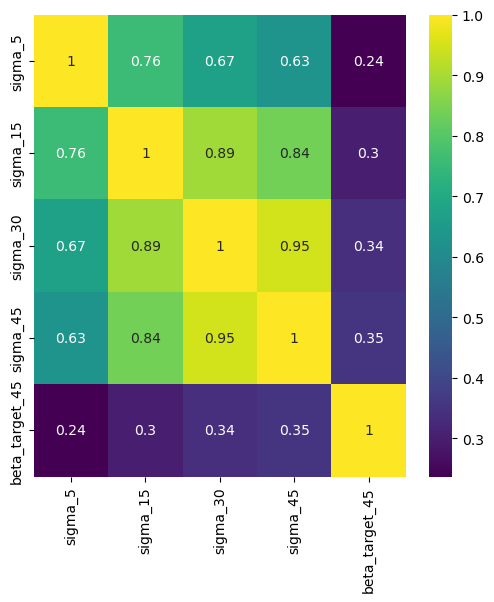

In [27]:
feature_heatmap([f'sigma_{i}' for i in feature_window_span])
# beta_feature_scatter('sigma_45')
# feature_scatter('sigma_45', 'beta_target_45')

* The longer the averaging window of the feature, the stronger the correlation

## Return to spy return ratio

In [28]:
train['sigma_ratio'] = train.groupby('Code', group_keys=False)['sigma_15'].apply(
    lambda x: x/train.loc[1320, 'sigma_15'])
# beta_feature_imp('sigma_ratio')

## Bollinger band feature

In [29]:
def calc_bbands(periods:list, series_col:str, data:pd.DataFrame = None):
    if data == None: data = train
    for p in periods:
        bbmid_col = f'sma_{p}'
        data[bbmid_col] = data.groupby('Code')[series_col].rolling(p).mean().droplevel(0)
        bb_std = data.groupby('Code')[series_col].rolling(p).std().droplevel(0)
        data[f'bbhigh_{p}'] = data[bbmid_col] + 2*bb_std
        data[f'bblow_{p}'] = data[bbmid_col] - 2*bb_std
        data[f'bbceil_{p}'] = 1-data[series_col]/data[f'bbhigh_{p}']
        data[f'bbfloor_{p}'] = 1-data[f'bblow_{p}']/data[series_col]
        # data[f'bbdiff_{p}'] = data[f'bbceil_{p}']+data[f'bbfloor_{p}']

calc_bbands(feature_window_span, 'CumulativeReturn')
train

RowId    Open    High     Low   Close  Volume  \
Code Date                                                                
1301 2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   31400   
     2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   17900   
     2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   19900   
     2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   24200   
     2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0    9300   
...                        ...     ...     ...     ...     ...     ...   
9997 2021-11-29  20211129_9997   678.0   679.0   665.0   668.0  320800   
     2021-11-30  20211130_9997   670.0   689.0   667.0   667.0  296300   
     2021-12-01  20211201_9997   661.0   688.0   660.0   685.0  339100   
     2021-12-02  20211202_9997   681.0   692.0   680.0   684.0  342900   
     2021-12-03  20211203_9997   690.0   711.0   686.0   696.0  381100   

                 AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
Code Date                                                              
1301 2017-01-04               1.0               NaN            False   
     2017-01-05               1.0               NaN            False   
     2017-01-06               1.0               NaN            False   
     2017-01-10               1.0               NaN            False   
     2017-01-11               1.0               NaN            False   
...                           ...               ...              ...   
9997 2021-11-29               1.0               NaN            False   
     2021-11-30               1.0               NaN            False   
     2021-12-01               1.0               NaN            False   
     2021-12-02               1.0               NaN            False   
     2021-12-03               1.0               NaN            False   

                 CumulativeAdjustmentFactor  ...    sma_30  bbhigh_30  \
Code Date                                    ...                        
1301 2017-01-04                         1.0  ...       NaN        NaN   
     2017-01-05                         1.0  ...       NaN        NaN   
     2017-01-06                         1.0  ...       NaN        NaN   
     2017-01-10                         1.0  ...       NaN        NaN   
     2017-01-11                         1.0  ...       NaN        NaN   
...                                     ...  ...       ...        ...   
9997 2021-11-29                         1.0  ...  0.982991   1.101375   
     2021-11-30                         1.0  ...  0.975878   1.098037   
     2021-12-01                         1.0  ...  0.969494   1.090886   
     2021-12-02                         1.0  ...  0.963282   1.083401   
     2021-12-03                         1.0  ...  0.958012   1.075747   

                 bblow_30  bbceil_30  bbfloor_30    sma_45  bbhigh_45  \
Code Date                                                               
1301 2017-01-04       NaN        NaN         NaN       NaN        NaN   
     2017-01-05       NaN        NaN         NaN       NaN        NaN   
     2017-01-06       NaN        NaN         NaN       NaN        NaN   
     2017-01-10       NaN        NaN         NaN       NaN        NaN   
     2017-01-11       NaN        NaN         NaN       NaN        NaN   
...                   ...        ...         ...       ...        ...   
9997 2021-11-29  0.864606   0.220418   -0.006982  1.013767   1.145426   
     2021-11-30  0.853720   0.219219    0.004207  1.008426   1.145546   
     2021-12-01  0.848103   0.192892    0.036753  1.003542   1.142920   
     2021-12-02  0.843163   0.188503    0.040964  0.999057   1.141201   
     2021-12-03  0.840277   0.168390    0.060725  0.994887   1.138053   

                 bblow_45  bbceil_45  bbfloor_45  
Code Date                                         
1301 2017-01-04       NaN        NaN         NaN  
     2017-01-05       NaN        NaN         NaN  
     2017-01-06      

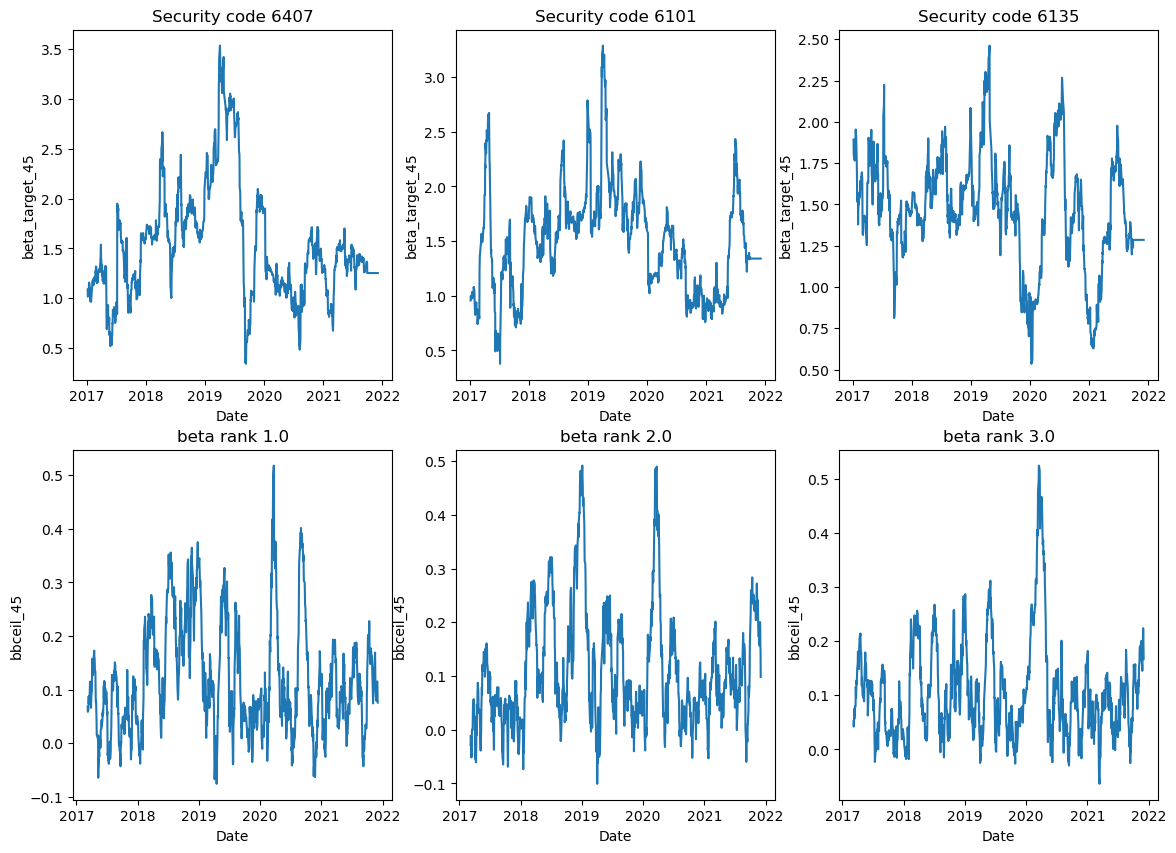

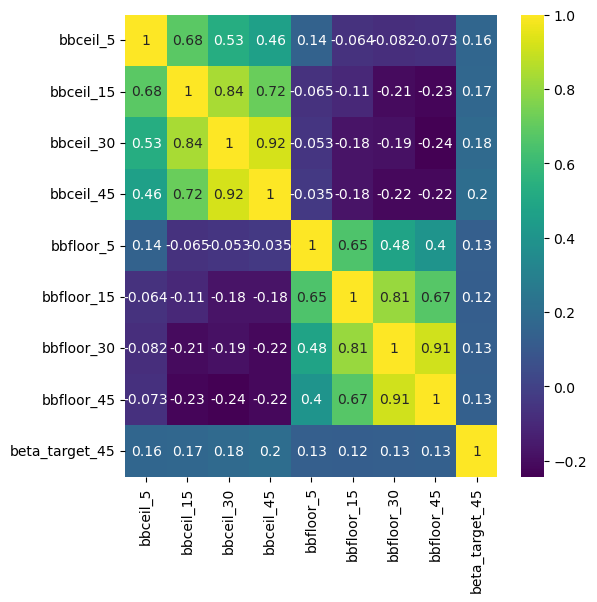

In [30]:
feature_timeseries_plot(top3_betas, 'bbceil_45', 'beta_target_45')

bb_feats = [f'bbceil_{i}' for i in feature_window_span]+[f'bbfloor_{i}' for i in feature_window_span]#+[f'bbdiff_{i}' for i in feature_window_span]
feature_heatmap(bb_feats, targets = ['beta_target_45'])

## ATR features

In [31]:
train['ATR_1'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['High'] - x['Low'])*x['AdjustmentFactor'].cumprod()).droplevel(0)
train['ATR_2'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['High'] - x['Open'])*x['AdjustmentFactor'].cumprod()).droplevel(0)
train['ATR_3'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['Open'] - x['Low'])*x['AdjustmentFactor'].cumprod()).droplevel(0)

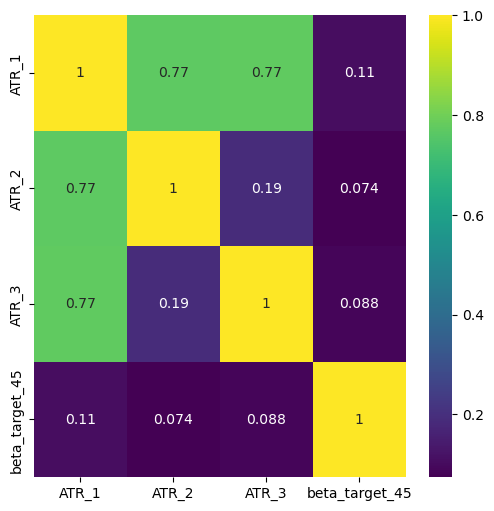

In [32]:
feature_heatmap(['ATR_1', 'ATR_2', 'ATR_3'])

(2085813, 6)


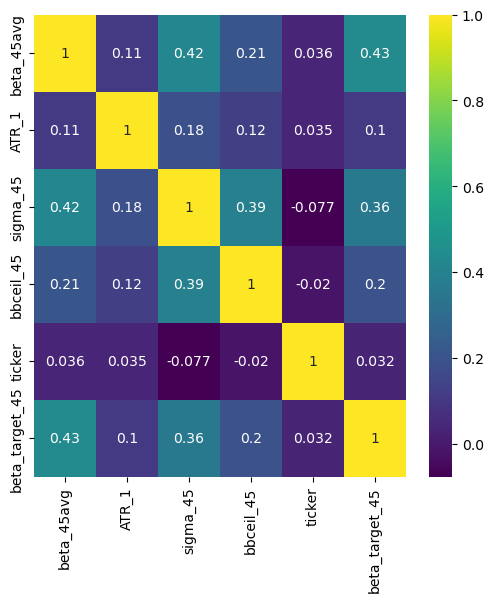

In [33]:
train['ticker'] = train.index.get_level_values(0)
train['month'] = train.index.get_level_values(1).month 
train['week'] = train.index.get_level_values(1).isocalendar().week.values
atr_feats = [f'ATR_{i+1}' for i in range(3)]
vol_feats = [f'sigma_{i}' for i in feature_window_span]

# I'll forego cat
# cat_feats = ['ticker', 'month', 'week']
cat_feats = ['ticker']
# cat_feats = []
train[cat_feats] = train[cat_feats].astype('category')

custom_picked_feats = [
    'beta_45avg', 
    'ATR_1', 
    'sigma_45',
    'bbceil_45', 
    ]


# beta_feature_list = atr_feats+vol_feats+bb_feats +cat_feats
beta_feature_list =custom_picked_feats+cat_feats

target = 'beta_target_45'

feature_heatmap(beta_feature_list, [target])


holdout = 2021


# train['beta'] = np.log1p(train['beta'])
nan_cuttoff_date = '2017-3-10'

try:
    train = train.drop(index=1320, axis=0)
except:
    print('market index has already been removed')
train = train.loc[idx[:, nan_cuttoff_date:'2021-11-15'], beta_feature_list+[target]].dropna()
print(train.shape)
X = train.loc[idx[:, '2017':str(holdout-1)], beta_feature_list].copy()
y = train.loc[idx[:, '2017': str(holdout-1)], target].copy()

X_holdout = train.loc[idx[:, str(holdout)], beta_feature_list].copy()
y_holdout = train.loc[idx[:, str(holdout)], target].copy()



# Cross validation scheme

I'll use a custom cross validator from Stefan Jansen's github that accepts a multindex dataframe has a class argument.  
* Leave the most recent year out as a holdout set for evaluation
* I'll make my train period 1 year to capture any seasonal effects, and test on half a year
* Using the time seires walk forward approach, data on January 2017 - December 2021 should yield about **6** training and validation sets with **1** holdout test set on the full year  of 2021

In [34]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(1).unique()
        days = sorted(unique_dates, reverse=True)
        # days = unique_dates
        # days = sorted(unique_dates, reverse=False)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()['Date']
        # self.dates = dates
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates > days[train_start])
                              & (dates <= days[train_end])].index
            test_idx = dates[(dates > days[test_start])
                             & (dates <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

cv = MultipleTimeSeriesCV(n_splits=6, train_period_length=220-45, test_period_length=110, lookahead=45)

i = 0
for train_idx, test_idx in cv.split(X=X):
    X_train = X.iloc[train_idx]
    train_dates = X_train.index.get_level_values(1)
    X_test = X.iloc[test_idx]
    test_dates = X_test.index.get_level_values(1)
    df = pd.concat((X_train.reset_index(), X_test.reset_index()), axis = 0)
    n = len(df)
    # assert n== len(df.drop_duplicates())
    print(X_train.groupby(level=0).size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          X_test.groupby(level=0).size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break


219 2019-06-20 2020-05-18 110 2020-07-20 2020-12-30
219 2019-01-04 2019-11-28 110 2020-02-06 2020-07-17
219 2018-07-23 2019-06-18 110 2019-08-22 2020-02-05
219 2018-02-09 2018-12-27 110 2019-03-08 2019-08-21
219 2017-08-29 2018-07-19 110 2018-09-21 2019-03-07
219 2017-03-21 2018-02-07 110 2018-04-13 2018-09-20


# Ridge regression

In [35]:

ridge_model_names = [f'ridge_model_{i}' for i in range(cv.n_splits)]
metrics_df_ridge = pd.DataFrame(
    index=['rmse', 'mae', 'pearson_r', 'spearman_r'],
    columns=ridge_model_names
)
train_predictions_ridge = pd.DataFrame(index=X.index.to_numpy(), columns=ridge_model_names)

ridge_models = {}
ridge_cv_results = {}  

ridge_params = {
    'alpha': 3,  # regularization param
    'max_iter': 10000,  # Increase if needed for convergence
    'tol': 1e-3,
    'random_state': 42  # Ensure reproducibility
}

for i, (train_idx, test_idx) in enumerate(cv.split(X)):
    model_no = f'ridge_model_{i}'
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    model = Ridge(**ridge_params)
    model.fit(X_train, y_train)

    ridge_models[model_no] = model
    ypred_test = model.predict(X_test)

    metrics_df_ridge.loc['rmse', model_no] = mean_squared_error(y_test, ypred_test, squared=False)
    metrics_df_ridge.loc['mae', model_no] = mean_absolute_error(y_test, ypred_test)
    metrics_df_ridge.loc['pearson_r', model_no] = pearsonr(y_test, ypred_test)[0]
    metrics_df_ridge.loc['spearman_r', model_no] = spearmanr(y_test, ypred_test)[0]

    train_predictions_ridge.loc[:, model_no] = model.predict(X)

# View the metrics for Ridge regression
display(metrics_df_ridge)


,ridge_model_0,ridge_model_1,ridge_model_2,ridge_model_3,ridge_model_4,ridge_model_5
rmse,0.397446,0.400444,0.435048,0.418642,0.399454,0.395501
mae,0.309737,0.316371,0.323128,0.316886,0.311254,0.299872
pearson_r,0.427624,0.476643,0.385765,0.542654,0.570272,0.469796
spearman_r,0.424386,0.469289,0.418255,0.558935,0.575394,0.490667


Pearson correlation on training set: PearsonRResult(statistic=0.4581178555072744, pvalue=0.0)
Pearson correlation on holdout set: PearsonRResult(statistic=0.5518363020731362, pvalue=0.0)


,ridge_model_0,ridge_model_1,ridge_model_2,ridge_model_3,ridge_model_4,ridge_model_5
rmse,0.291364,0.294734,0.313184,0.298543,0.298624,0.305361
mae,0.224113,0.224593,0.245585,0.230906,0.232484,0.239065
pearson_r,0.543097,0.528308,0.5571,0.541954,0.532077,0.513151
spearman_r,0.556004,0.542892,0.574582,0.562519,0.55337,0.533851
pearson_weight,0.16889,0.164291,0.173245,0.168534,0.165463,0.159577


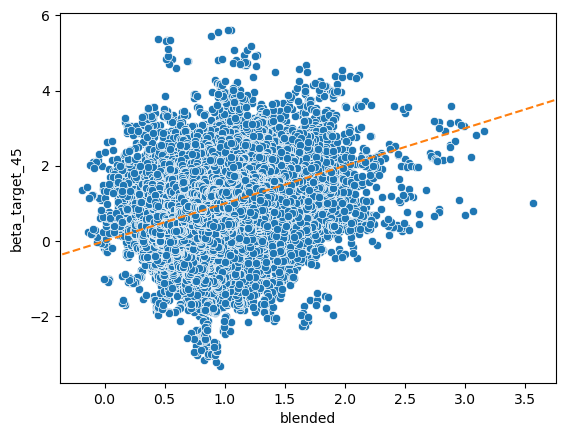

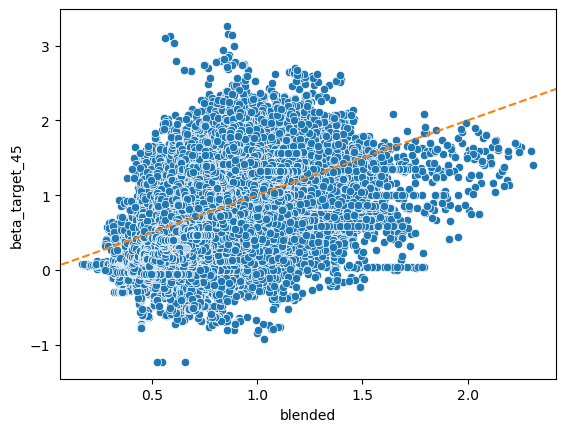

In [36]:

metrics_df_ridge.loc['pearson_weight'] = metrics_df_ridge.loc['pearson_r'] / metrics_df_ridge.loc['pearson_r'].sum()

train_predictions_ridge['blended'] = (train_predictions_ridge * metrics_df_ridge.loc['pearson_weight']).sum(axis=1)

fig, ax = plt.subplots()

sns.scatterplot(x=train_predictions_ridge['blended'], y=y, ax=ax)
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='tab:orange')

pearson_train = pearsonr(train_predictions_ridge['blended'], y.dropna())
print(f"Pearson correlation on training set: {pearson_train}")

holdout_predictions_ridge = pd.DataFrame(columns=ridge_model_names, index=y_holdout.index)
holdout_metrics_ridge = pd.DataFrame(index=metrics_df_ridge.index, columns=metrics_df_ridge.columns)

for key in ridge_models.keys():
    model = ridge_models[key]
    ypred = model.predict(X_holdout)
    holdout_predictions_ridge[key] = ypred

    holdout_metrics_ridge.loc['rmse', key] = mean_squared_error(ypred, y_holdout, squared=False)
    holdout_metrics_ridge.loc['mae', key] = mean_absolute_error(ypred, y_holdout)
    holdout_metrics_ridge.loc['pearson_r', key] = pearsonr(ypred, y_holdout)[0]
    holdout_metrics_ridge.loc['spearman_r', key] = spearmanr(ypred, y_holdout)[0]

holdout_metrics_ridge.loc['pearson_weight'] = holdout_metrics_ridge.loc['pearson_r'] / holdout_metrics_ridge.loc['pearson_r'].sum()

holdout_predictions_ridge['blended'] = (holdout_predictions_ridge * holdout_metrics_ridge.loc['pearson_weight']).sum(axis=1)

fig, ax = plt.subplots()

sns.scatterplot(x=holdout_predictions_ridge['blended'], y=y_holdout, ax=ax)
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([y_holdout.min(), y_holdout.max()], [y_holdout.min(), y_holdout.max()], '--', color='tab:orange')

pearson_holdout = pearsonr(holdout_predictions_ridge['blended'], y_holdout)
print(f"Pearson correlation on holdout set: {pearson_holdout}")

display(holdout_metrics_ridge)


## Ridge regresion model evaulation
* The baseline model is just the historical 45 day average of $\beta$. Baseline pearson correlation was 0.4
* Ridge regression outperforms the baseline with a pearson correlation of around 0.52 to 0.55.
* Further improvements could be made from categorical encoding or feature engineering from impplied probability distributions

<!-- # XGBoost
* My knowledge of XGBoost is still growing but the key ingredients come from 
    * Gradient boosting (core algo is adaboost)
    * Random forests and decision trees
    * L1 and L2 regularization -->

In [37]:

# model_names = [f'model_{i}' for i in range(cv.n_splits)]
# metrics_df = pd.DataFrame(
#     index = ['rmse', 'mae', 'pearson_r', 'spearman_r']
#     , columns = model_names
# )
# train_predictions = pd.DataFrame(index = X.index.to_numpy(), columns = model_names)

# xgb_models = {}
# xgb_cv_results = {}

# xgb_params = {
#     'enable_categorical': True,
#     'n_estimators': 300,
#     'verbose': False,
#     'early_stopping_rounds': 10,
#     'eta': 0.05,
#     'objective':'reg:squarederror',
#     'verbosity':0,
#     'eval_metric': ['rmse', 'mae'],
#     'max_depth': 6,#6,
#     # 'gamma': 0.5,
#     'min_child_weight': 1,
#     'booster': 'gbtree',
#     'tree_method': 'hist',
#     'sampling_method': 'gradient_based',
#     'subsample':0.1,
#     'colsample_bytree':0.5,
#     'colsample_bylevel': 1,
#     # 'alpha': 200,#10,
#     # 'lambda': 300,#30,
#     'device': 'cuda',
# }
# for i, (train_idx, test_idx) in enumerate(cv.split(X)):
#     model_no = f'model_{i}'

#     X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#     X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]


#     model = xgb.XGBRegressor(**xgb_params)
#     eval_set = (X_test, y_test)
#     eval_results = []
#     model.fit(
#         X = X_train, y= y_train,
#         eval_set = [(X_train, y_train), (X_test, y_test)],
#         verbose=False
#     )

#     xgb_models[model_no] = model
#     xgb_cv_results[model_no] = model.evals_result()

#     ypred_test = model.predict(X_test)

#     metrics_df.loc['rmse', model_no] = mean_squared_error(y_test, ypred_test, squared=False)
#     metrics_df.loc['mae', model_no] = mean_absolute_error(y_test, ypred_test)
#     metrics_df.loc['pearson_r', model_no] = pearsonr(y_test, ypred_test)[0]
#     metrics_df.loc['spearman_r', model_no] = spearmanr(y_test, ypred_test)[0]
#     train_predictions.loc[:, model_no] = model.predict(X)


In [38]:
# fig, ax = plt.subplots(cv.n_splits, 2, figsize = (3*2, 18), tight_layout = True)
# for i, fold_no in enumerate(xgb_cv_results.keys()):

#     fold = xgb_cv_results[fold_no]

#     for j, set_no in enumerate(fold.keys()):
#         set = fold[set_no]
#         for k, metric in enumerate(set.keys()):
#             data = np.array((set[metric]))
#             ax[i, k].plot(data)
            

In [39]:
# metrics_df.loc['pearson_weight'] = metrics_df.loc['pearson_r']/metrics_df.loc['pearson_r'].sum()
# train_predictions['blended'] = (train_predictions*metrics_df.loc['pearson_weight']).sum(axis = 1)

# fig, ax = plt.subplots()

# sns.scatterplot(x=train_predictions['blended'],y= y)
# ax.set_xlim(ax.get_xlim())
# ax.set_ylim(ax.get_ylim())
# ax.plot([y.min(), y.max()], [y.min(), y.max()], '--',color = 'tab:orange')

In [40]:
# pearsonr(train_predictions['blended'], y.dropna())

In [41]:
# holdout_predictions = pd.DataFrame(columns = model_names, index = y_holdout.index)
# holdout_metrics = pd.DataFrame(index = metrics_df.index, columns =metrics_df.columns)
# for key in xgb_models.keys():
#     model = xgb_models[key]
#     ypred = model.predict(X_holdout)
#     holdout_predictions[key] = ypred

#     holdout_metrics.loc['rmse', key] = mean_squared_error(ypred, y_holdout, squared=False)
#     holdout_metrics.loc['mae', key] = mean_absolute_error(ypred, y_holdout)
#     holdout_metrics.loc['pearson_r', key] = pearsonr(ypred, y_holdout)[0]
#     holdout_metrics.loc['spearman_r', key] = spearmanr(ypred, y_holdout)[0]

# holdout_metrics.loc['pearson_weight']= holdout_metrics.loc['pearson_r']/holdout_metrics.loc['pearson_r'].sum()
# display(holdout_metrics)

# holdout_predictions['blended'] = (holdout_predictions*holdout_metrics.loc['pearson_weight']).sum(axis=1)

# fig, ax = plt.subplots()

# sns.scatterplot(x=holdout_predictions['blended'],y= y_holdout)
# ax.set_xlim(ax.get_xlim())
# ax.set_ylim(ax.get_ylim())
# ax.plot([y.min(), y.max()], [y_holdout.min(), y_holdout.max()], '--',color = 'tab:orange')

In [42]:
# 

<!-- ## XGBoost evaluation

* There's high variance in the training performance.  Some epochs have strong degree of overfitting, some epochs have (too) remarkable fits.
* The pearson r on the holdout dataset is 0.6, greater than ridge regression by the same margin as ridge versus the baseline. -->